# Womens Clothing Reviews Sentiment Analysis

**This project will use the Women's E-commerce Clothing Reviews from Kaggle to demonstrate the power of the Naive Bayes algorithm in Binary Classification.**

**The primary focus of this project will be text analysis and therefore unnecessary columns will be removed and focus will be on the reviews column.**

**Problem Type: Binary Classification**

**Statement: Using the given data, develop a classifier that can predict if a review is Positeve or Negative.**

This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

* Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
* Age: Positive Integer variable of the reviewers age.
* Title: String variable for the title of the review.
* Review Text: String variable for the review body.
* Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
* Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
* Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
* Division Name: Categorical name of the product high level division.
* Department Name: Categorical name of the product department name.
* Class Name: Categorical name of the product class name.

## Approach to the Problem:

* Importing the Libraries
* Reading The Data
* Understanding the Data
* Checking for Null Values
* Removing Unnecessary Columns
* Removing Rows with Null Values
* Creating the binary Sentiment Column(Target Variable)
* Exploratory Data Analysis
* Data Visualization
* Preprocessing of the Review Text Column
* Stemming the Reviews
* Splitting The Data 
* Creating Feature Vectors from the Reviews
* Training Multinomial Naive Bayes Classifiers
* Analysing Performance and Predictions.

## Importing The Necessary Libraries and Functions

In [58]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import sklearn.metrics as mt
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
data = pd.read_csv("Womens Clothing E-Commerce Reviews.csv") # reading the data
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


**We can see that the given columns have a few null values that need to be handled.**
* Title
* Review Text
* Division Name
* Department Name 
* Class Name

In [10]:
data.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


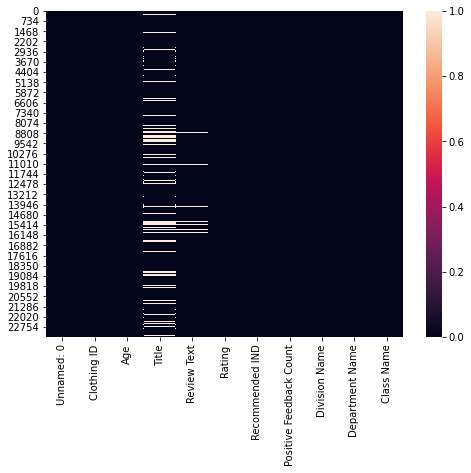

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(data.isnull()) # The WHITE REGION shows the NULL values in the data

**Now removing the columns that are not of much use for us in our text based analysis.**

In [12]:
data.drop(['Unnamed: 0', "Clothing ID","Title", "Recommended IND", "Division Name", "Department Name","Positive Feedback Count"], axis =1, inplace=True)

In [13]:
data.head()

,Age,Review Text,Rating,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,60,I had such high hopes for this dress and reall...,3,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants
4,47,This shirt is very flattering to all due to th...,5,Blouses


In [14]:
print("Number of null values in Review Text column.",data[data['Review Text'].isnull()==True].shape[0])
print("Number of null values in Class Name column.",data[data['Class Name'].isnull()==True].shape[0])

Number of null values in Review Text column. 845
Number of null values in Class Name column. 14


**We have enough data for out analysis so we can simply drop the rows with null values.**

In [15]:
data.dropna(inplace=True)
data.shape

(22628, 4)

Since we do not have a column which shows the sentiment as positive or negative in the dataset, A new **sentiment column** will be created. To do this,it is assumed the reviews which have **4 or higher** rating as **positive (True in the new dataframe)** and **2 or lower** rating as **negative (False in the new dataframe)**. Also, the rows that have neutral ratings which are equal to **3** are not included. 

In [16]:
data = data[data['Rating'] != 3]
data['Sentiment'] = data['Rating'] >= 4
data['Sentiment'] = data['Sentiment'].map({True:1,False:0})
data.head()

,Age,Review Text,Rating,Class Name,Sentiment
0,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates,1
1,34,Love this dress! it's sooo pretty. i happene...,5,Dresses,1
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,1
4,47,This shirt is very flattering to all due to th...,5,Blouses,1
5,49,"I love tracy reese dresses, but this one is no...",2,Dresses,0


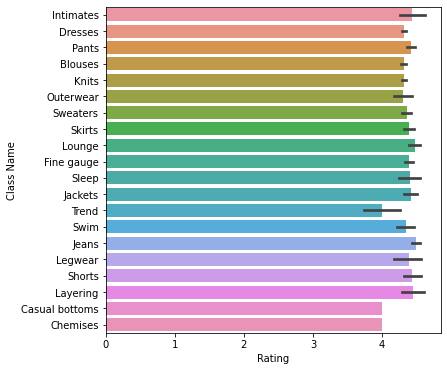

In [17]:
plt.figure(figsize=(6,6))
sns.barplot(data['Rating'], data['Class Name'])

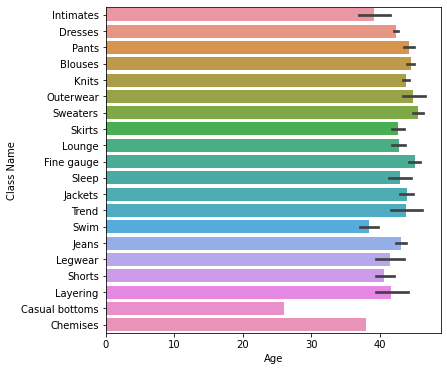

In [18]:
plt.figure(figsize=(6,6))
sns.barplot(data['Age'], data['Class Name'])

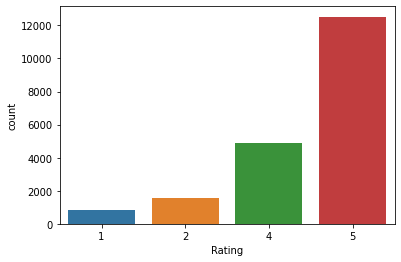

In [19]:
sns.countplot(data['Rating'])

We can see that Rating of 4 and 5 are in majority as compared to ratings of 1 and 2. Therefore we can say that based on this, our target variable ie, Sentiment column will be unbalanced. Hence our **dataset is unbalanced**.

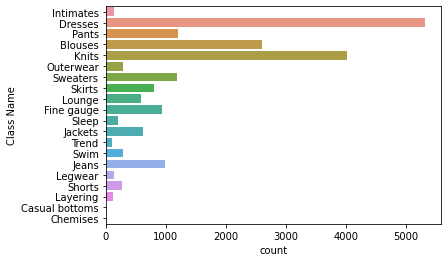

In [20]:
sns.countplot(y = data['Class Name'],)

In the Class Names, Dresses, Knits and Blouses dominate all other classes. On the other hand, some classes namely Chemises, Casual bottoms, Intimates , trend etc, have very few data points. 

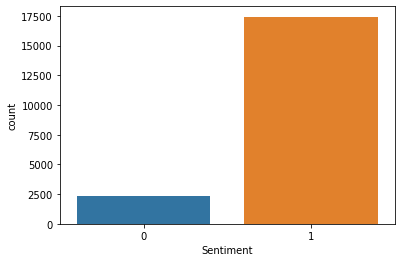

In [21]:
sns.countplot(data['Sentiment'])

**We can see that out data is imbalanced.**

**Now I will preprocess the Review Text Column and create feature vectors from the Reviews to build the Classifier.**

## Data Preprocessing

In [22]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(data['Review Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #preprocessed_tweets.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english')))
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords.words())
    preprocessed_text.append(sentance.strip())

100%|██████████| 19805/19805 [1:09:19<00:00,  4.76it/s]


In [24]:
data['processed text'] = preprocessed_text
data.head()

,Age,Review Text,Rating,Class Name,Sentiment,processed text
0,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates,1,absolutely wonderful silky sexy comfortable
1,34,Love this dress! it's sooo pretty. i happene...,5,Dresses,1,love dress sooo pretty happened find store gla...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,1,love love love jumpsuit fun flirty fabulous ev...
4,47,This shirt is very flattering to all due to th...,5,Blouses,1,shirt flattering due adjustable front tie perf...
5,49,"I love tracy reese dresses, but this one is no...",2,Dresses,0,love tracy reese dresses petite feet tall usua...


In [25]:
data.to_csv("processed_wcr.csv")

In [3]:
data = pd.read_csv("processed_wcr.csv")

In [11]:
# STEMMING THE DATA AND ADDING IT TO DATAFRAME.
new_list = []
for text in tqdm(data['processed text'].values):
    text = text.split()
    stemmer = SnowballStemmer("english")
    stemmed_text = []
    for word in text:
        word = stemmer.stem(word)
        stemmed_text.append(word)
    new_list.append(" ".join(stemmed_text))
new_list[:5]

100%|██████████████████████████████████████████████████████████████████████████| 19805/19805 [00:15<00:00, 1251.47it/s]


['absolut wonder silki sexi comfort',
 'love dress sooo pretti happen find store glad bc never would order onlin bc petit bought petit love length hit littl knee would definit true midi someon truli petit',
 'love love love jumpsuit fun flirti fabul everi time wear get noth great compliment',
 'shirt flatter due adjust front tie perfect length wear leg sleeveless pair well cardigan love shirt',
 'love traci rees dress petit feet tall usual wear brand dress pretti packag lot dress skirt long full overwhelm small frame stranger alter shorten narrow skirt would away embellish garment love color idea style work return dress']

In [12]:
data['Stemmed text'] = new_list
data.head()

,Unnamed: 0,Age,Review Text,Rating,Class Name,Sentiment,processed text,Stemmed text
0,0,33,Absolutely wonderful - silky and sexy and comf...,4,Intimates,1,absolutely wonderful silky sexy comfortable,absolut wonder silki sexi comfort
1,1,34,Love this dress! it's sooo pretty. i happene...,5,Dresses,1,love dress sooo pretty happened find store gla...,love dress sooo pretti happen find store glad ...
2,3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,1,love love love jumpsuit fun flirty fabulous ev...,love love love jumpsuit fun flirti fabul everi...
3,4,47,This shirt is very flattering to all due to th...,5,Blouses,1,shirt flattering due adjustable front tie perf...,shirt flatter due adjust front tie perfect len...
4,5,49,"I love tracy reese dresses, but this one is no...",2,Dresses,0,love tracy reese dresses petite feet tall usua...,love traci rees dress petit feet tall usual we...


**Now, only the stemmed text and sentiment column will be useful for our furthur analysis, therefore they will be put in a seaprate dataframe.**

In [13]:
df = data[['Sentiment',"Stemmed text"]]
df.head()

,Sentiment,Stemmed text
0,1,absolut wonder silki sexi comfort
1,1,love dress sooo pretti happen find store glad ...
2,1,love love love jumpsuit fun flirti fabul everi...
3,1,shirt flatter due adjust front tie perfect len...
4,0,love traci rees dress petit feet tall usual we...


**Now we need to split the data and form feature vectors from the Stemmed text, using Bag of Words.**

In [44]:
X=df['Stemmed text']
y=df['Sentiment']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

In [31]:
print("No. of rows in training data: ", x_train.shape[0])
print("No. of rows in testing data: ", x_test.shape[0])

No. of rows in training data:  13269
No. of rows in testing data:  6536


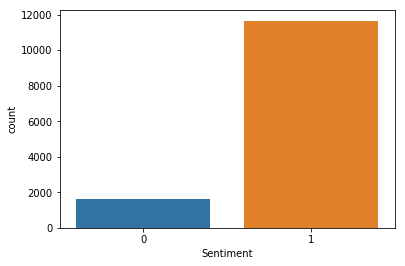

In [32]:
# Checking the distribution of target variable in both training data and test data
sns.countplot(y_train)

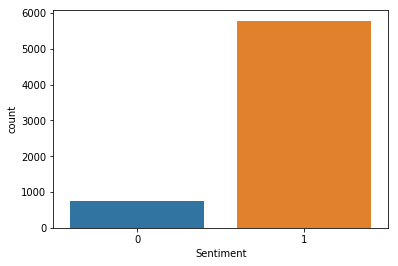

In [33]:
sns.countplot(y_test)

## Feature Engineering And Modelling
**Creating BOW from the training data.**

In [82]:
def vectorize_train(n1,n2,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    vec = CountVectorizer(ngram_range=(n1,n2))  # Unigramns only
    x_train = vec.fit_transform(x_train)
    x_test = vec.transform(x_test)
    model= MultinomialNB()
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    sns.heatmap(confusion_matrix(y_test,pred),annot=True)
    print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.74      0.62      0.68       809
           1       0.95      0.97      0.96      5727

    accuracy                           0.93      6536
   macro avg       0.85      0.80      0.82      6536
weighted avg       0.92      0.93      0.92      6536



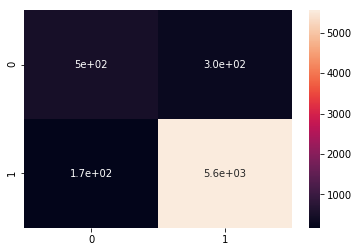

In [83]:
vectorize_train(1,1)

              precision    recall  f1-score   support

           0       0.97      0.07      0.13       809
           1       0.88      1.00      0.94      5727

    accuracy                           0.88      6536
   macro avg       0.92      0.53      0.53      6536
weighted avg       0.89      0.88      0.84      6536



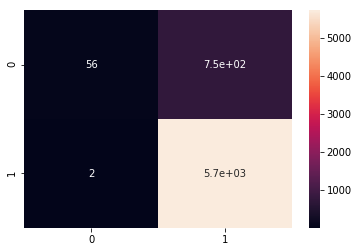

In [84]:
vectorize_train(1,2)

              precision    recall  f1-score   support

           0       0.92      0.18      0.30       809
           1       0.90      1.00      0.94      5727

    accuracy                           0.90      6536
   macro avg       0.91      0.59      0.62      6536
weighted avg       0.90      0.90      0.86      6536



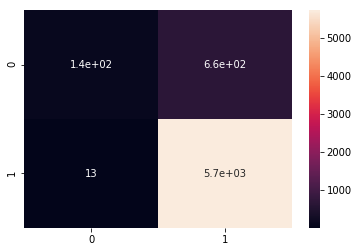

In [85]:
vectorize_train(2,2)

## Results:

**From the above results we can see that the model trained using Unigrams gives the best results. The other two models overfit on the majority class due to the large number of features.**